# Predicting OBP

To briefly outline the steps I will take:

First, I will explore and clean the dataset, and engineer relevant predictors. Then, I will employ a formal machine-learning workflow to train an optimally-tuned model to predict OBP based on the predictors. The details of this workflow are below, in the Model Training section.

## Imports and Setup

In [77]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# See https://stackoverflow.com/questions/62825515/jupyter-lab-is-not-printing-all-parameters-form-sklearn-model
from sklearn import set_config
set_config(print_changed_only = False)

# RNG Seed
seed = 1072022

## Explore and Clean Dataset

In [78]:
df = pd.read_csv('batting.csv')
df.head()

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_ISO,MarApr_BABIP,MarApr_AVG,MarApr_OBP,MarApr_SLG,MarApr_LD%,MarApr_GB%,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP
0,15998,Cody Bellinger,LAD,132,109,47,14,32,37,5,14.4%,11.4%,0.459,0.398,0.431,0.508,0.890,34.0%,29.9%,36.1%,5.7%,40.0%,22.6%,66.0%,40.7%,81.1%,88.4%,86.0%,0.406
1,11477,Christian Yelich,MIL,124,102,36,14,26,34,6,16.1%,16.1%,0.451,0.319,0.353,0.460,0.804,15.7%,43.4%,41.0%,11.8%,41.2%,27.9%,72.4%,44.8%,56.6%,87.8%,75.7%,0.429
2,17975,Scott Kingery,PHI,35,32,13,2,5,6,1,2.9%,14.3%,0.313,0.440,0.406,0.457,0.719,14.8%,51.9%,33.3%,0.0%,22.2%,40.2%,74.5%,53.5%,54.3%,85.4%,71.1%,0.315
3,7927,Eric Sogard,TOR,49,43,17,3,8,9,2,10.2%,10.2%,0.302,0.400,0.395,0.458,0.698,29.7%,29.7%,40.5%,0.0%,20.0%,27.3%,50.5%,37.3%,93.9%,97.8%,96.2%,0.353
4,14130,Daniel Vogelbach,SEA,92,71,22,8,15,16,0,21.7%,21.7%,0.423,0.318,0.310,0.457,0.732,21.2%,26.9%,51.9%,7.4%,29.6%,23.7%,48.8%,33.7%,66.1%,82.7%,75.7%,0.341


The percentage variables need to be converted to numerics:

In [79]:
df.dtypes

playerid               int64
Name                  object
Team                  object
MarApr_PA              int64
MarApr_AB              int64
MarApr_H               int64
MarApr_HR              int64
MarApr_R               int64
MarApr_RBI             int64
MarApr_SB              int64
MarApr_BB%            object
MarApr_K%             object
MarApr_ISO           float64
MarApr_BABIP         float64
MarApr_AVG           float64
MarApr_OBP           float64
MarApr_SLG           float64
MarApr_LD%            object
MarApr_GB%            object
MarApr_FB%            object
MarApr_IFFB%          object
MarApr_HR/FB          object
MarApr_O-Swing%       object
MarApr_Z-Swing%       object
MarApr_Swing%         object
MarApr_O-Contact%     object
MarApr_Z-Contact%     object
MarApr_Contact%       object
FullSeason_OBP       float64
dtype: object

In [80]:
# Convert percentage variables to numeric
pct_vars = [col for col in df.columns if '%' in col] + ['MarApr_HR/FB']
for var in pct_vars:
    df[var] = df[var].str.replace('%', '', regex = False).astype(float)

# All good now
df.dtypes

playerid               int64
Name                  object
Team                  object
MarApr_PA              int64
MarApr_AB              int64
MarApr_H               int64
MarApr_HR              int64
MarApr_R               int64
MarApr_RBI             int64
MarApr_SB              int64
MarApr_BB%           float64
MarApr_K%            float64
MarApr_ISO           float64
MarApr_BABIP         float64
MarApr_AVG           float64
MarApr_OBP           float64
MarApr_SLG           float64
MarApr_LD%           float64
MarApr_GB%           float64
MarApr_FB%           float64
MarApr_IFFB%         float64
MarApr_HR/FB         float64
MarApr_O-Swing%      float64
MarApr_Z-Swing%      float64
MarApr_Swing%        float64
MarApr_O-Contact%    float64
MarApr_Z-Contact%    float64
MarApr_Contact%      float64
FullSeason_OBP       float64
dtype: object

Two players are missing a team:

In [81]:
df.groupby(df.Team).size()

Team
- - -     2
ARI      10
ATL      11
BAL      10
BOS      10
CHC      10
CHW      12
CIN       9
CLE      12
COL      12
DET      11
HOU      12
KCR       9
LAA      10
LAD      11
MIA       8
MIL      12
MIN      13
NYM      12
NYY      11
OAK      11
PHI       8
PIT      10
SDP      11
SEA      12
SFG       8
STL      10
TBR      11
TEX      12
TOR      10
WSN      10
dtype: int64

The two players are Tyler Austin and Kevin Pillar, who were both traded in early April, midway through the period covered by these data. One way to handle this is to drop them outright. But I'd prefer to keep them and assign a dummy for them. This will be taken care of automatically when I make team dummies in the next section.

In [82]:
df[df.Team == '- - -'].Name

135    Tyler Austin
279    Kevin Pillar
Name: Name, dtype: object

Finally, subset to the variables I want to keep:

In [83]:
df.drop(columns = ['playerid', 'Name'], inplace = True)
df.head()

,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_ISO,MarApr_BABIP,MarApr_AVG,MarApr_OBP,MarApr_SLG,MarApr_LD%,MarApr_GB%,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP
0,LAD,132,109,47,14,32,37,5,14.4,11.4,0.459,0.398,0.431,0.508,0.890,34.0,29.9,36.1,5.7,40.0,22.6,66.0,40.7,81.1,88.4,86.0,0.406
1,MIL,124,102,36,14,26,34,6,16.1,16.1,0.451,0.319,0.353,0.460,0.804,15.7,43.4,41.0,11.8,41.2,27.9,72.4,44.8,56.6,87.8,75.7,0.429
2,PHI,35,32,13,2,5,6,1,2.9,14.3,0.313,0.440,0.406,0.457,0.719,14.8,51.9,33.3,0.0,22.2,40.2,74.5,53.5,54.3,85.4,71.1,0.315
3,TOR,49,43,17,3,8,9,2,10.2,10.2,0.302,0.400,0.395,0.458,0.698,29.7,29.7,40.5,0.0,20.0,27.3,50.5,37.3,93.9,97.8,96.2,0.353
4,SEA,92,71,22,8,15,16,0,21.7,21.7,0.423,0.318,0.310,0.457,0.732,21.2,26.9,51.9,7.4,29.6,23.7,48.8,33.7,66.1,82.7,75.7,0.341


## Feature Engineering

First let's convert the team variable to a set of dummies. (Notice that Austin and Pillar get their own dummy as desired.)

In [84]:
df = pd.get_dummies(df, columns = ['Team'])
df.head()

,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_ISO,MarApr_BABIP,MarApr_AVG,MarApr_OBP,MarApr_SLG,MarApr_LD%,MarApr_GB%,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP,Team_- - -,Team_ARI,Team_ATL,Team_BAL,Team_BOS,Team_CHC,Team_CHW,Team_CIN,Team_CLE,Team_COL,Team_DET,Team_HOU,Team_KCR,Team_LAA,Team_LAD,Team_MIA,Team_MIL,Team_MIN,Team_NYM,Team_NYY,Team_OAK,Team_PHI,Team_PIT,Team_SDP,Team_SEA,Team_SFG,Team_STL,Team_TBR,Team_TEX,Team_TOR,Team_WSN
0,132,109,47,14,32,37,5,14.4,11.4,0.459,0.398,0.431,0.508,0.890,34.0,29.9,36.1,5.7,40.0,22.6,66.0,40.7,81.1,88.4,86.0,0.406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,124,102,36,14,26,34,6,16.1,16.1,0.451,0.319,0.353,0.460,0.804,15.7,43.4,41.0,11.8,41.2,27.9,72.4,44.8,56.6,87.8,75.7,0.429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35,32,13,2,5,6,1,2.9,14.3,0.313,0.440,0.406,0.457,0.719,14.8,51.9,33.3,0.0,22.2,40.2,74.5,53.5,54.3,85.4,71.1,0.315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,49,43,17,3,8,9,2,10.2,10.2,0.302,0.400,0.395,0.458,0.698,29.7,29.7,40.5,0.0,20.0,27.3,50.5,37.3,93.9,97.8,96.2,0.353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,92,71,22,8,15,16,0,21.7,21.7,0.423,0.318,0.310,0.457,0.732,21.2,26.9,51.9,7.4,29.6,23.7,48.8,33.7,66.1,82.7,75.7,0.341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Next, generate quadratic and cubic terms for the non-dummy variables:

In [85]:
numeric_vars = [col for col in df.columns if 'MarApr_' in col]
for var in numeric_vars:
    df['{}2'.format(var)] = np.power(df[var], 2)
    df['{}3'.format(var)] = np.power(df[var], 3)
df.head()

,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_ISO,MarApr_BABIP,MarApr_AVG,MarApr_OBP,MarApr_SLG,MarApr_LD%,MarApr_GB%,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP,Team_- - -,Team_ARI,Team_ATL,Team_BAL,Team_BOS,Team_CHC,Team_CHW,Team_CIN,Team_CLE,Team_COL,Team_DET,Team_HOU,Team_KCR,Team_LAA,Team_LAD,Team_MIA,Team_MIL,Team_MIN,Team_NYM,Team_NYY,Team_OAK,Team_PHI,Team_PIT,Team_SDP,...,MarApr_PA2,MarApr_PA3,MarApr_AB2,MarApr_AB3,MarApr_H2,MarApr_H3,MarApr_HR2,MarApr_HR3,MarApr_R2,MarApr_R3,MarApr_RBI2,MarApr_RBI3,MarApr_SB2,MarApr_SB3,MarApr_BB%2,MarApr_BB%3,MarApr_K%2,MarApr_K%3,MarApr_ISO2,MarApr_ISO3,MarApr_BABIP2,MarApr_BABIP3,MarApr_AVG2,MarApr_AVG3,MarApr_OBP2,MarApr_OBP3,MarApr_SLG2,MarApr_SLG3,MarApr_LD%2,MarApr_LD%3,MarApr_GB%2,MarApr_GB%3,MarApr_FB%2,MarApr_FB%3,MarApr_IFFB%2,MarApr_IFFB%3,MarApr_HR/FB2,MarApr_HR/FB3,MarApr_O-Swing%2,MarApr_O-Swing%3,MarApr_Z-Swing%2,MarApr_Z-Swing%3,MarApr_Swing%2,MarApr_Swing%3,MarApr_O-Contact%2,MarApr_O-Contact%3,MarApr_Z-Contact%2,MarApr_Z-Contact%3,MarApr_Contact%2,MarApr_Contact%3
0,132,109,47,14,32,37,5,14.4,11.4,0.459,0.398,0.431,0.508,0.890,34.0,29.9,36.1,5.7,40.0,22.6,66.0,40.7,81.1,88.4,86.0,0.406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,17424,2299968,11881,1295029,2209,103823,196,2744,1024,32768,1369,50653,25,125,207.36,2985.984,129.96,1481.544,0.210681,0.096703,0.158404,0.063045,0.185761,0.080063,0.258064,0.131097,0.792100,0.704969,1156.00,39304.000,894.01,26730.899,1303.21,47045.881,32.49,185.193,1600.00,64000.000,510.76,11543.176,4356.00,287496.000,1656.49,67419.143,6577.21,533411.731,7814.56,690807.104,7396.00,636056.000
1,124,102,36,14,26,34,6,16.1,16.1,0.451,0.319,0.353,0.460,0.804,15.7,43.4,41.0,11.8,41.2,27.9,72.4,44.8,56.6,87.8,75.7,0.429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,15376,1906624,10404,1061208,1296,46656,196,2744,676,17576,1156,39304,36,216,259.21,4173.281,259.21,4173.281,0.203401,0.091734,0.101761,0.032462,0.124609,0.043987,0.211600,0.097336,0.646416,0.519718,246.49,3869.893,1883.56,81746.504,1681.00,68921.000,139.24,1643.032,1697.44,69934.528,778.41,21717.639,5241.76,379503.424,2007.04,89915.392,3203.56,181321.496,7708.84,676836.152,5730.49,433798.093
2,35,32,13,2,5,6,1,2.9,14.3,0.313,0.440,0.406,0.457,0.719,14.8,51.9,33.3,0.0,22.2,40.2,74.5,53.5,54.3,85.4,71.1,0.315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1225,42875,1024,32768,169,2197,4,8,25,125,36,216,1,1,8.41,24.389,204.49,2924.207,0.097969,0.030664,0.193600,0.085184,0.164836,0.066923,0.208849,0.095444,0.516961,0.371695,219.04,3241.792,2693.61,139798.359,1108.89,36926.037,0.00,0.000,492.84,10941.048,1616.04,64964.808,5550.25,413493.625,2862.25,153130.375,2948.49,160103.007,7293.16,622835.864,5055.21,359425.431
3,49,43,17,3,8,9,2,10.2,10.2,0.302,0.400,0.395,0.458,0.698,29.7,29.7,40.5,0.0,20.0,27.3,50.5,37.3,93.9,97.8,96.2,0.353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2401,117649,1849,79507,289,4913,9,27,64,512,81,729,4,8,104.04,1061.208,104.04,1061.208,0.091204,0.027544,0.160000,0.064000,0.156025,0.061630,0.209764,0.096072,0.487204,0.340068,882.09,26198.073,882.09,26198.073,1640.25,66430.125,0.00,0.000,400.00,8000.000,745.29,20346.417,2550.25,128787.625,1391.29,51895.117,8817.21,827936.019,9564.84,935441.352,9254.44,890277.128
4,92,71,22,8,15,16,0,21.7,21.7,0.423,0.318,0.310,0.457,0.732,21.2,26.9,51.9,7.4,29.6,23.7,48.8,33.7,66.1,82.7,75.7,0.341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8464,778688,5041,357911,484,10648,64,512,225,3375,256,4096,0,0,470.89,10218.313,470.89,10218.313,0.178929,0.075687,0.101124,0.032157,0.096100,0.029791,0.208849,0.095444,0.535824,0.392223,449.44,9528.128,723.61,19465.109,2693.61,139798.359,54.76,405.224,876.16,25934.336,561.69,13312.053,2381.44,116214.272,1135.69,38272.753,4369.21,288804.781,6839.29,565609.283,5730.49,433798.093


Give the final analytical base table a new name:

In [86]:
abt = df.copy()

We're now ready to train the model.

## Model Training

I will train and select the optimal model as follows. First, I will split the data into a training set, consisting of 80% of the rows (randomly drawn), and a test set, consisting of the remaining 20%. I will train five classes of models on the training data, each one on a grid of hyperparameters. For each model class, I will choose the optimal hyperparameters by 10-fold cross validation on the training data. With the optimal hyperparameters for each model class in hand, I can see how the optimal models perform on the *test* data, and use standard accuracy metrics to determine which among them performs best.

The five model classes I will train are LASSO, ridge regression, elastic net, random forest, and gradient boosting.

In [87]:
# Target variable
y = abt.FullSeason_OBP

# Input features
X = abt.drop(columns = 'FullSeason_OBP')

# Split sample into test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
print(len(X_train), len(X_test), len(y_train), len(y_test))

256 64 256 64


In [88]:
# Pipelines
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state = seed)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state = seed)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state = seed)),
    'rf'    : make_pipeline(StandardScaler(), RandomForestRegressor(random_state = seed)),
    'gb'    : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state = seed))
}

In choosing hyperparameter grids, I "cheat" a little bit. I began with standard grids covering what I believe to be a broad swathe of the parameter space. Once I found the optimal hyperparameters for each model, I checked to see if any of them were on the "edges" of their respective grids. If they were, I "expanded" the grid further out, by what I believed to be a reasonable interval. This is to ensure that the hyperparameter choices truly are optimal, and not simply constrained by my choices of grid. Note that in practice, my initial grids were mostly sufficient: The only hyperparameter grid that needed expanding was that for ridge regression.

In [89]:
# Hyperparameter grids

# LASSO
lasso_hyperparameters = { 
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100] 
}

# Ridge
ridge_hyperparameters = { 
    'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 200, 500, 750]  
}

# Elastic net
enet_hyperparameters = { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100],                        
    'elasticnet__l1_ratio' : [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]  
}

# Random forest
rf_hyperparameters = {
    'randomforestregressor__n_estimators' : [50, 100, 150, 200, 250, 300],
    'randomforestregressor__max_features' : ['auto', 'sqrt', 0.33],
    'randomforestregressor__max_depth' : [1, 3, 5, 7, 9]
}

# Gradient boosting
gb_hyperparameters = {
    'gradientboostingregressor__n_estimators' : [50, 100, 200],
    'gradientboostingregressor__learning_rate' : [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth' : [1, 3, 5, 7, 9]
}

# Gather grids
hyperparameters = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet'  : enet_hyperparameters,
    'rf'    : rf_hyperparameters,
    'gb'    : gb_hyperparameters
}

In [90]:
# Fit models

# Initialize models dictionary
fitted_models = {}

# Loop over model pipelines, tuning each model and storing the output
for method, pipeline in pipelines.items():
    
    # Initialize model/grid search object
    model = GridSearchCV(pipeline, hyperparameters[method], cv = 10, n_jobs = -1)
    
    # Train model on training data for all hyperparameters
    model.fit(X_train, y_train)
    
    # Store output
    fitted_models[method] = model
    
    print(method, 'has been fitted.')

# Confirm for sure that models were fitted correctly
for method, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print('Confirmed:', method, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.
Confirmed: lasso has been fitted.
Confirmed: ridge has been fitted.
Confirmed: enet has been fitted.
Confirmed: rf has been fitted.
Confirmed: gb has been fitted.


## Model Selection

Before moving to the test data, let's look at the models' performances on the training data. Below I report the mean cross-validated R-squared for each model with its optimal hyperparameters.

The tree-based models perform best on the training data, with random forest coming in first.

In [95]:
for method, model in fitted_models.items():
    print(method, '\n',
          '--------', '\n',
          'best R-sqared: ', model.best_score_, '\n',
          'best parameters: ', model.best_params_, '\n\n',
          sep = '')

lasso
--------
best R-sqared: 0.33037911943582243
best parameters: {'lasso__alpha': 0.005}


ridge
--------
best R-sqared: 0.37550920624832407
best parameters: {'ridge__alpha': 500}


enet
--------
best R-sqared: 0.34470077445210134
best parameters: {'elasticnet__alpha': 0.05, 'elasticnet__l1_ratio': 0.05}


rf
--------
best R-sqared: 0.40320490120189023
best parameters: {'randomforestregressor__max_depth': 3, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 250}


gb
--------
best R-sqared: 0.3700548980640789
best parameters: {'gradientboostingregressor__learning_rate': 0.02, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 100}




Let's see how the models perform on the test data:

In [96]:
for method, model in fitted_models.items():
    pred = model.predict(X_test)
    print(method, '\n',
          '--------', '\n',
          'R-squared: ', r2_score(y_test, pred), '\n',
          'MSE: ', mean_squared_error(y_test, pred), '\n',
          'MAE: ', mean_absolute_error(y_test, pred), '\n\n',
         sep = '')

lasso
--------
R-squared: 0.29012138361378714
MSE: 0.0007131812157304158
MAE: 0.02123414076055944


ridge
--------
R-squared: 0.3808886992753411
MSE: 0.0006219916193151396
MAE: 0.020356269388406976


enet
--------
R-squared: 0.3294645460891261
MSE: 0.0006736550153390294
MAE: 0.021006339568407847


rf
--------
R-squared: 0.23566115612879146
MSE: 0.0007678948109143748
MAE: 0.022826581618073362


gb
--------
R-squared: 0.2892505731900581
MSE: 0.0007140560774635771
MAE: 0.021795627084940254




On the test data, ridge regression comes out ahead, and the tree-based methods are generally behind. This suggests that the tree-based methods were overfitting on the training data (as those methods are prone to doing, even with hyperparameter tuning).

## Results

The optimal model is able to explain ~38% of the variation in OBP. Further, the OBPs it predicts differ from true OBP by an average of 2 percentage points.

Below I plot the actual OBPs in the test set against their corresponding predicted OBPs under this model.

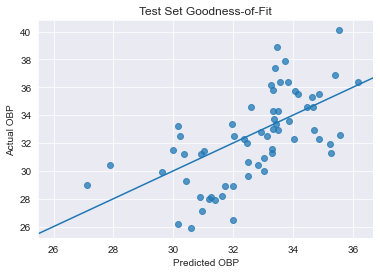

In [97]:
plt.scatter(fitted_models['ridge'].predict(X_test)*100, y_test*100, alpha = 0.75)
plt.axline([26, 26], slope = 1)
plt.xlabel('Predicted OBP')
plt.ylabel('Actual OBP')
plt.title('Test Set Goodness-of-Fit')
plt.show()